In [1]:
import torch, torchvision
import mmdet
import pytesseract
from PIL import Image,ImageEnhance,ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
pytesseract.pytesseract.tesseract_cmd = 'tesseract'
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import string
from string import digits,punctuation,ascii_letters
letters=digits+ascii_letters+' '+",.:-'()/\\"
import glob
import pandas as pd
import os, shutil
import cv2
from io import BytesIO
from collections import namedtuple
from concurrent.futures import ThreadPoolExecutor
import easyocr
reader = easyocr.Reader(['en'],recog_network='custom_example')
reader2 = easyocr.Reader(['en'])

/anaconda3/envs/mmdetect/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [3]:
from selenium import webdriver
chromeOptions = webdriver.ChromeOptions()
chromeOptions.add_argument("--headless")
chromeOptions.add_argument('--no-sandbox')
chromeOptions.add_argument("--window-size=6000x5000")
chromeOptions.add_argument("--disable-notifications")
chromeOptions.add_argument("--silent")
chromeOptions.add_argument("--log-level=1")
chromeOptions.add_argument("--verbose")
chromeOptions.add_argument("--log-path=chromedriver.log")
chromeOptions.add_argument('--ignore-certificate-errors')
chromeOptions.add_argument("--lang=en-US")
chromeOptions.add_argument("--window-size=6000x5000")
chromeOptions.add_experimental_option("prefs", {
    'profile.default_content_settings.images': 2,
    'translate_whitelists': {
        'sv':'en',
        'el':'en',
        'fi':'en',
        'de':'en',
        }, 
    'translate':{'enabled':'True'}, 
    'intl.accept_languages': 'en,en_US',
     })
chromeOptions.add_argument('disable-infobars')
chromeOptions.add_experimental_option("excludeSwitches", ["enable-automation"])

In [4]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
config='/root/Worley/mmdetection/configs/stocks/stock1.py'
checkpoint='/root/Worley/mmdetection/work_dirs/exp3/latest.pth'
model = init_detector(config, checkpoint=checkpoint, device='cuda:0')

load checkpoint from local path: /root/Worley/mmdetection/work_dirs/exp3/latest.pth


In [5]:
BLevel = namedtuple("BLevel", ['brange', 'bval'])

_blevels = [
    BLevel(brange=range(0, 24), bval=0),
    BLevel(brange=range(23, 47), bval=1),
    BLevel(brange=range(46, 70), bval=2),
    BLevel(brange=range(69, 93), bval=3),
    BLevel(brange=range(92, 116), bval=4),
    BLevel(brange=range(115, 140), bval=5),
    BLevel(brange=range(139, 163), bval=6),
    BLevel(brange=range(162, 186), bval=7),
    BLevel(brange=range(185, 209), bval=8),
    BLevel(brange=range(208, 232), bval=9),
    BLevel(brange=range(231, 256), bval=10),
]

def detect_level(h_val):
     h_val = int(h_val)
     for blevel in _blevels:
        if h_val in blevel.brange:
            return blevel.bval

def get_img_avg_brightness(file):
     img = cv2.imread(file)
     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
     _, _, v = cv2.split(hsv)
     return int(np.average(v.flatten()))

def enhancer(file):
    val=get_img_avg_brightness(file)
    brightness=detect_level(val)
    if brightness<7:
        im = Image.open(file)
        enhancer = ImageEnhance.Brightness(im)
        factor=10/brightness
        im_output = enhancer.enhance(factor)
        im_output.save(file)

In [6]:
def clear_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [7]:
def save_result(final):
    print('Saving the results into CSV file')
    res_df=pd.DataFrame(final)
    res_df=res_df.transpose()
    res_df['File']=res_df.index.to_list()
    res_df.reset_index(drop=True, inplace=True)
    res_df=res_df[['File','Date','Price','Ticker','Stock']]
    res_df.to_csv('scrape_results.csv',index=False)

In [8]:
def get_cord(model,img):
    result = inference_detector(model, img)
    result1=[]
    for j,i in enumerate(result):
        if not len(i):
            result1.append(np.array(i))
        elif len(i)==1:
            result1.append(np.array(i))
        else:
            value=np.argmax(i,axis=0)
            ap=np.array(i[0])
            ap=ap.reshape(-1,5)
            result1.append(ap)
    return result1

In [9]:
def crop(image,x0,y0,x1,y1,name):
    crop_dir='/root/Worley/mmdetection/crop_dir/'
    cropped_image=image.crop((x0,y0,x1,y1))
    gry = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_BGR2GRAY)
    blr = cv2.GaussianBlur(gry, (3, 3), 0)
    thr = cv2.threshold(blr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    plt.imshow(thr)
    plt.show()
    cv2.imwrite(crop_dir+name,thr)
    return thr

In [10]:
def text_process(text,label):
    if label=='Price':
        text=''.join([i for i in text if i in "1234567890.,'"])
    return text

In [20]:
def get_text2(image,label):
    text=reader.recognize(image)
    if text:text=text[0][1]
    else:text=''
    text=''.join([i for i in text if i in letters])
    return text

In [12]:
def get_text3(image,label):
    if label=='Price':
        text=reader2.readtext(image)
        if text:
            text=text[0][1]
        else:
            text=''
            text = pytesseract.image_to_string(image, lang="eng", config="--psm 6 --oem 2")            
        text=''.join([i for i in text if i in letters])            
    else:
        text = pytesseract.image_to_string(image, lang="eng",config="words --psm 6 --oem 2")
        text=''.join([i for i in text if i in letters])
        if text=='':
            text=reader2.readtext(image)
            if text:text=text[0][1]
            else:text=''
        text=''.join([i for i in text if i in letters])
    return text

In [13]:
def save_img(img,result1,out_path):
    result={'Date':'','Price':'','Ticker':'','Stock':''}
    maps={0:'Date',1:'Price',2:'Stock',3:'Ticker'}
    image = Image.open(img)
    image1=image.copy()
    name=img.split('/')[-1]
    plotted_image = ImageDraw.Draw(image)
    for ind,boxes in enumerate(result1):
        if len(boxes):
            x0,y0,x1,y1,conf=boxes[0]
            plotted_image.rectangle(((x0,y0), (x1,y1)),outline="red")
            cropped_image=crop(image1,x0,y0,x1,y1,str(ind)+name)
            label=str(maps[ind]) 
            text=get_text2(cropped_image,label)
            if text=='':
                cropped_image=crop(image1,x0+20,y0,x1,y1,name)
                text=get_text2(cropped_image,label)
            text=text_process(text,label)
            print(label+':'+text)
            result[label]=text
            plotted_image.text((x0, y0 - 10), str(label)+':'+str(text),fill='red')
    image.save(out_path+name)
    return result

In [14]:
# def temp(file):
#     out_path='/root/Worley/mmdetection/test1/'
#     print(file,out_path)
#     final={}
#     name=file.split('/')[-1]
#     enhancer(file)
#     res=get_cord(model,file)
#     result=save_img(file,res,out_path)
#     final[name]=result
#     return final

In [15]:
# def run_model(path,out_path):
#     path+='/*'
#     final={}
#     files=glob.glob(path)
#     with ThreadPoolExecutor(max_workers=48) as exe:
#         final=exe.map(temp,files)
#     print(final)

In [16]:
def run_model(path,out_path):
    print('Running Model')
    path+='/*'
    final={}
    clear_folder(out_path)
    print('Folder is truncated')
    for file in glob.glob(path):
        name=file.split('/')[-1]
        enhancer(file)
        res=get_cord(model,file)
        result=save_img(file,res,out_path)
        final[name]=result
    save_result(final)

In [17]:
def get_link(url,path,name):
    driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chromeOptions)
    try:
        driver.get(url)
        driver.implicitly_wait(10)
        driver.set_page_load_timeout(120)
        driver.execute_script("document.body.style.zoom = '450%'")
        element = driver.find_element_by_tag_name('body')
        location = element.location
        size = element.size
        png = driver.get_screenshot_as_png()
        driver.quit()
        right=(location['x'] + size['width']) * 4.5
        left = location['x'] * 4.5
        top = location['y'] * 4.5
        im = Image.open(BytesIO(png))
        im=im.crop((left+20,top,right-600,4500))
        figure(figsize=(12, 10), dpi=80)
        plt.imshow(im)
        plt.show()
        im.save(path+name+".png")
    except:
        pass

In [24]:
def scraper(input_file,image_path,out_path):
    clear_folder(image_path)
    df=pd.read_excel(input_file,sheet_name='Sheet1')  
    print('Fetching Websites ')
    print('Total pages-',len(df['Website URL'].tolist()))
    total_sites=df['Website URL'].tolist()
    for index,url in enumerate(total_sites):
        print("Running for the URL "+str(index+1)+"- ",url)
        name=url[8:].split('/')[0]+'_'+str(index)
        get_link(url,image_path,name)
#     run_model(image_path,out_path)

Fetching Websites 
Total pages- 31
Running for the URL 1-  https://finasko.com/nasdaq-100-index/


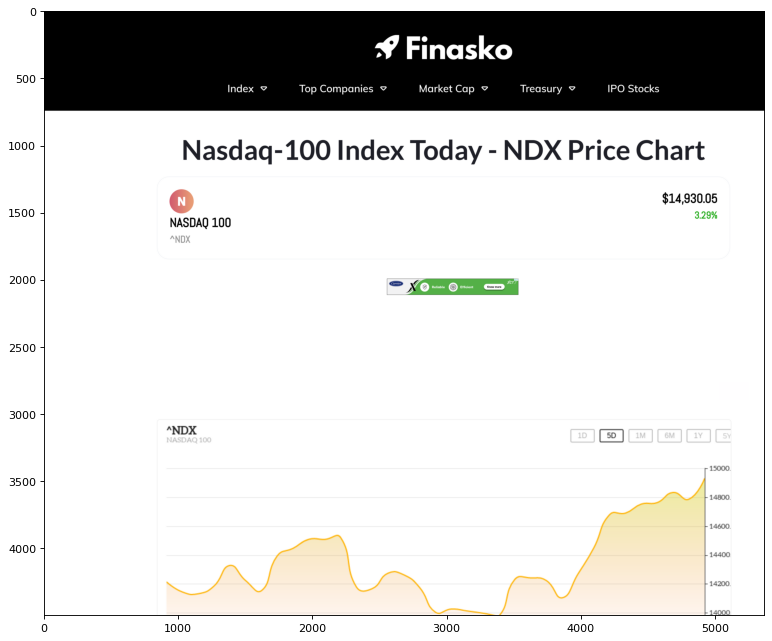

Running for the URL 2-  https://indexes.nasdaq.com/Index/Overview/NDX


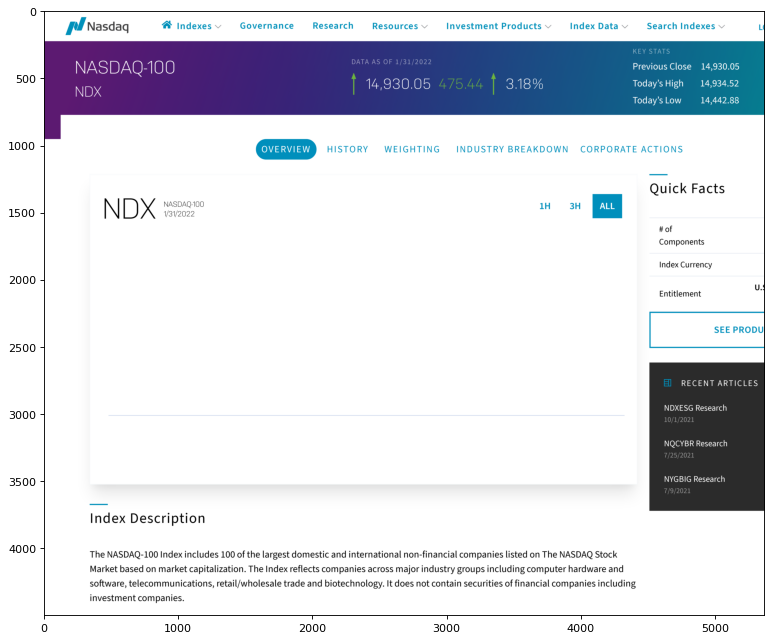

Running for the URL 3-  https://indexes.nasdaqomx.com/Index/Overview/NDX


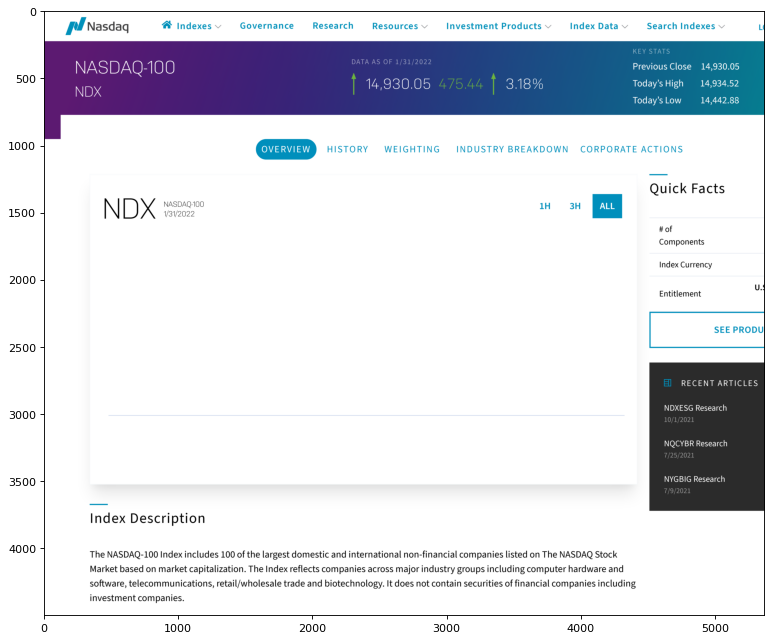

Running for the URL 4-  https://www.dailyfx.com/nas-100


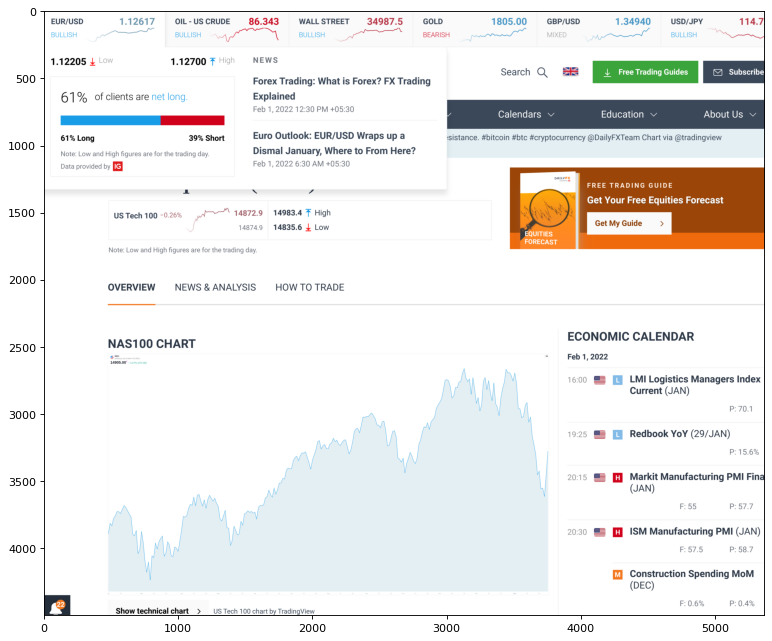

Running for the URL 5-  https://www.avatrade.com/cfd-trading/indices/nasdaq-100


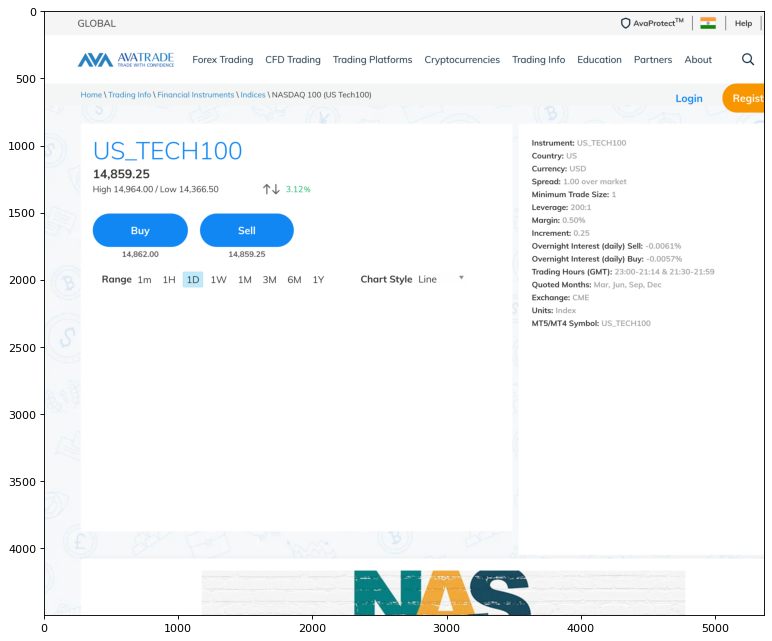

Running for the URL 6-  https://fi.investing.com/indices/omx-helsinki-25-components


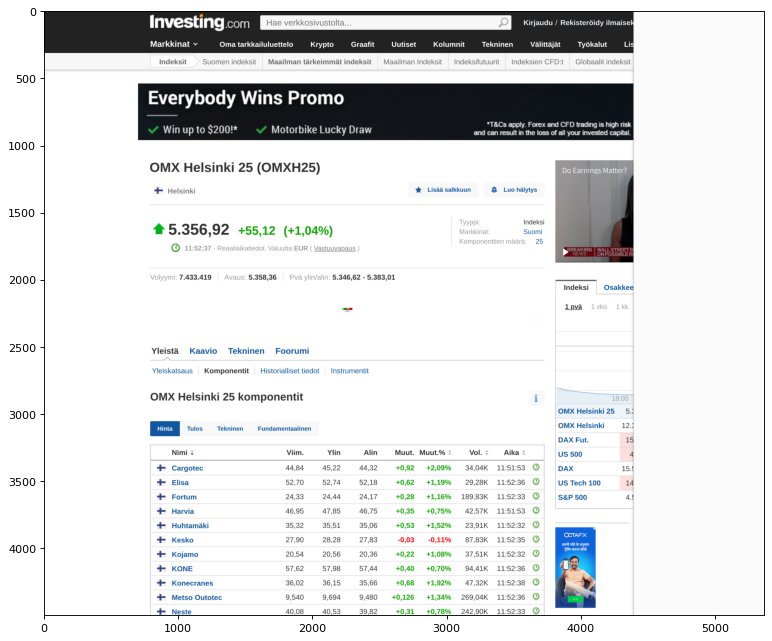

Running for the URL 7-  https://markets.ft.com/data/etfs/tearsheet/summary?s=FI0008805627


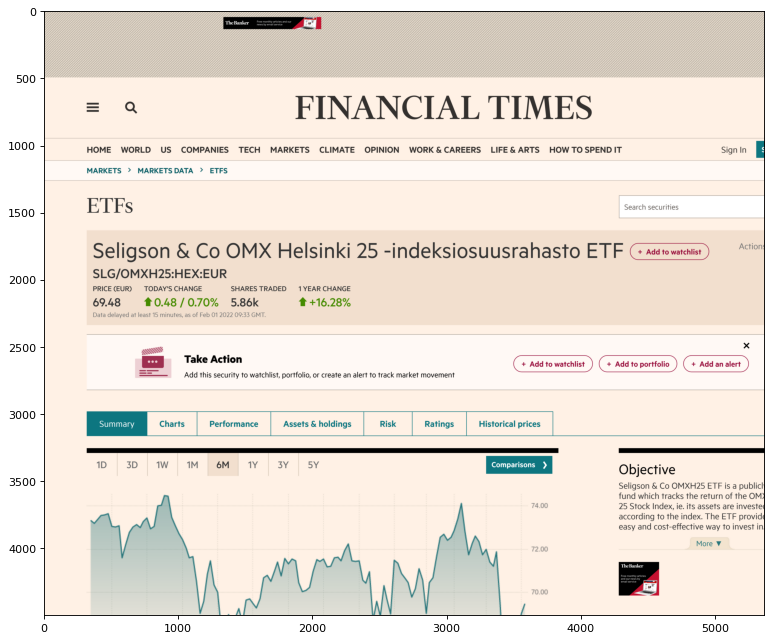

Running for the URL 8-  http://www.morningstar.is/is/etf/snapshot/snapshot.aspx?id=0P00000K38


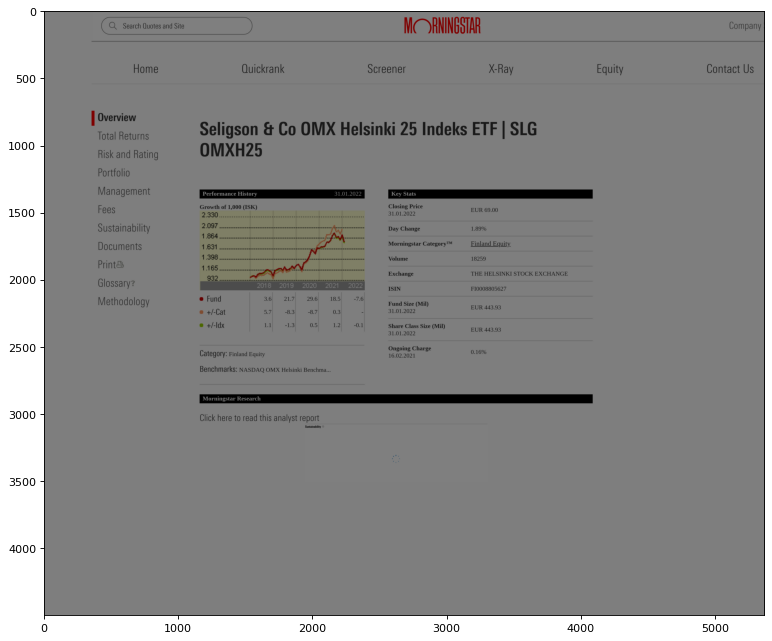

Running for the URL 9-  https://www.boursorama.com/bourse/indices/cours/$OMXH25/


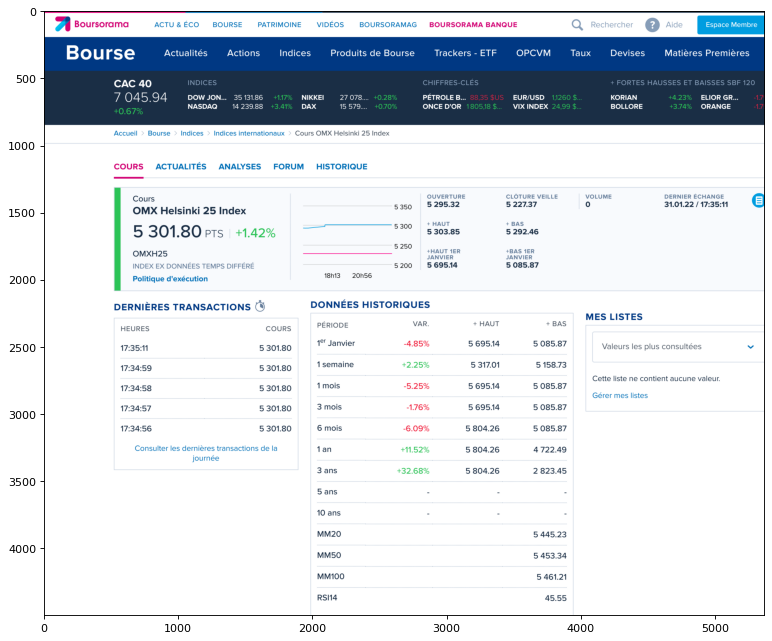

Running for the URL 10-  https://www.boursorama.com/bourse/indices/cours/%24NDX.X


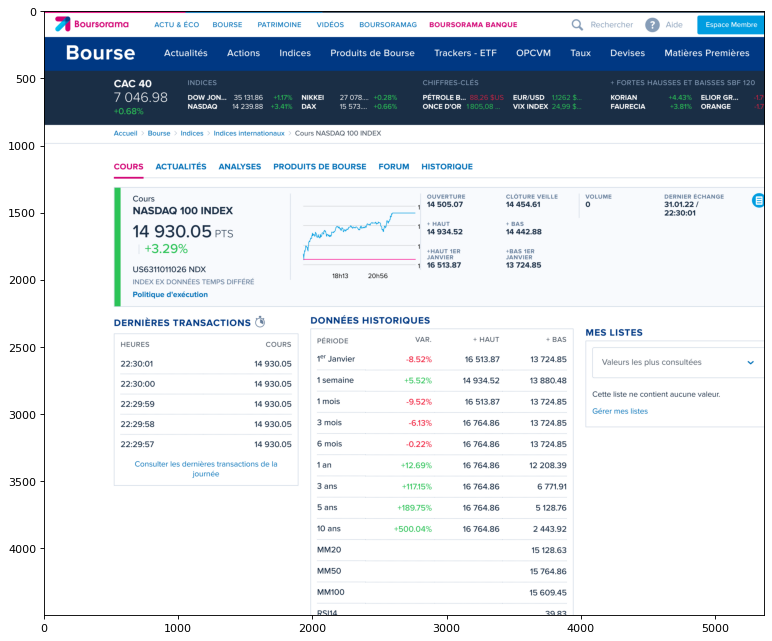

Running for the URL 11-  https://www.morningstar.dk/dk/etf/snapshot/snapshot.aspx?id=0P00000K38


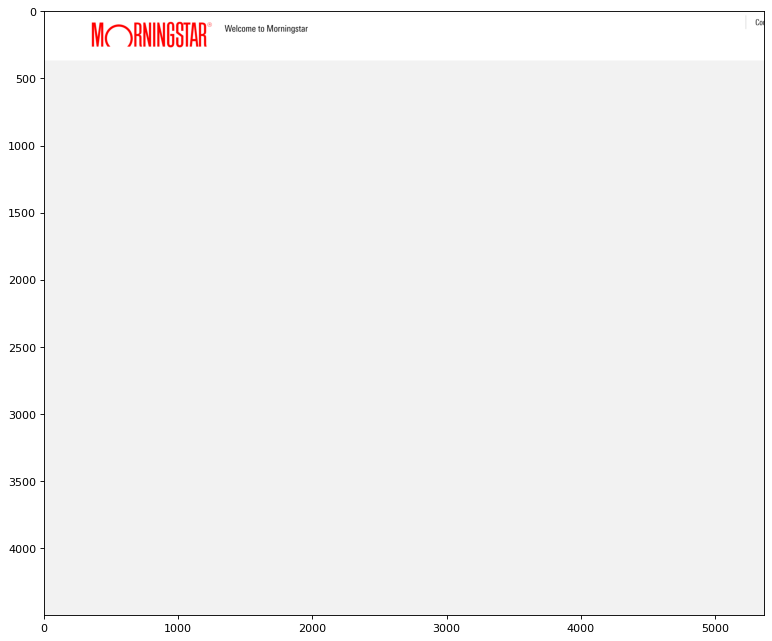

Running for the URL 12-  http://www.morningstar.co.uk/uk/etf/snapshot/snapshot.aspx?id=0P00000K38


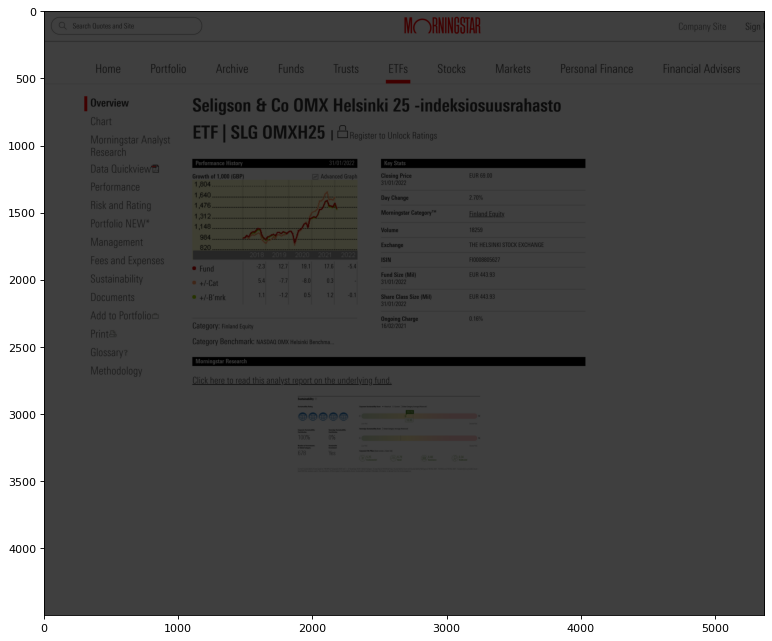

Running for the URL 13-  https://www.nordnet.fi/markkinakatsaus/etf-listat/16100898-seligson-co-omx


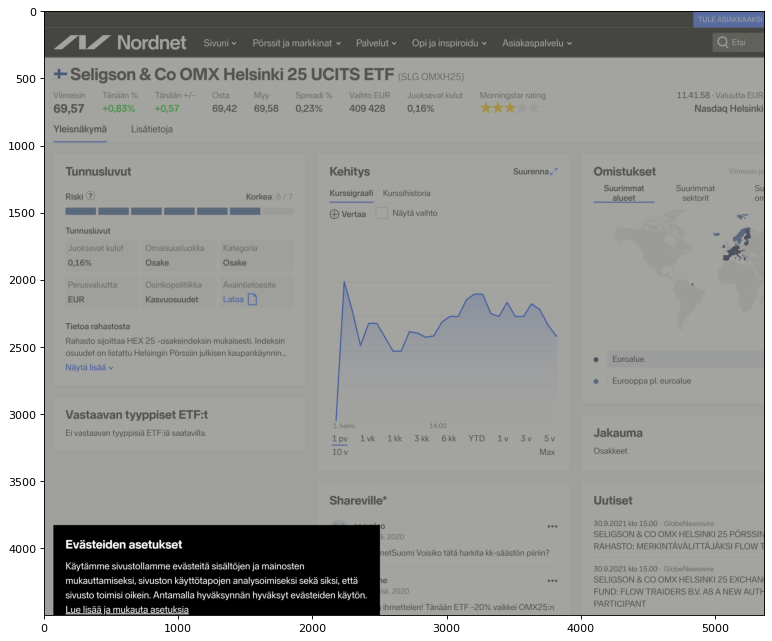

Running for the URL 14-  https://fi.investing.com/indices/omx-nordic-40


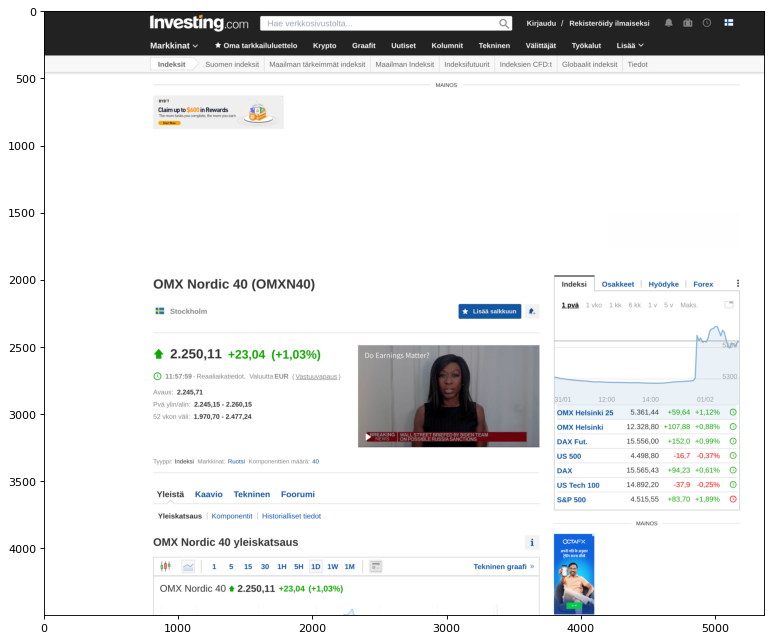

Running for the URL 15-  https://fi.investing.com/indices/omx-stockholm-30


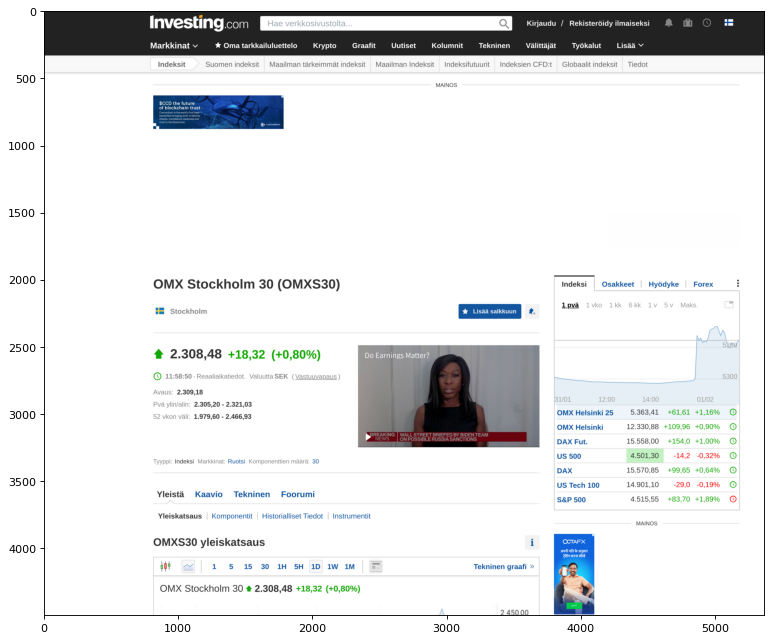

Running for the URL 16-  https://fi.investing.com/equities/shore-bancshares


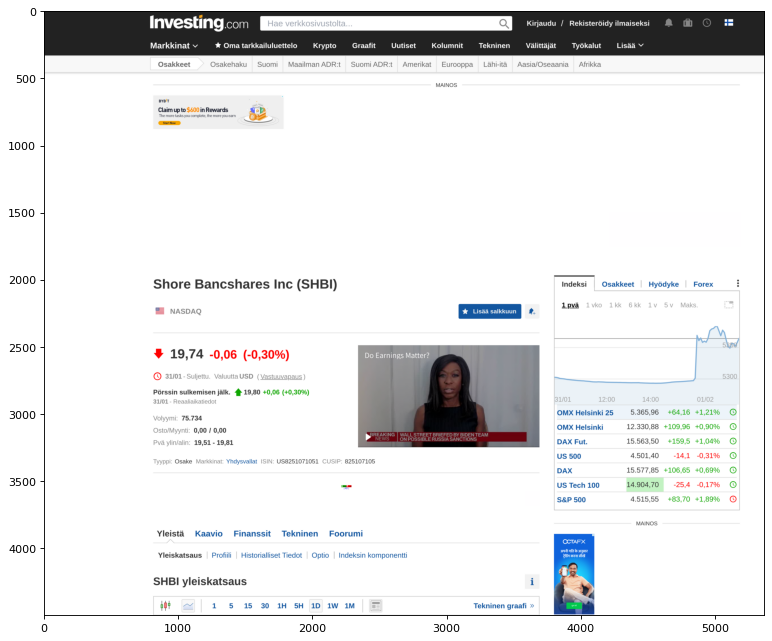

Running for the URL 17-  https://fi.investing.com/equities/priceline.com-inc


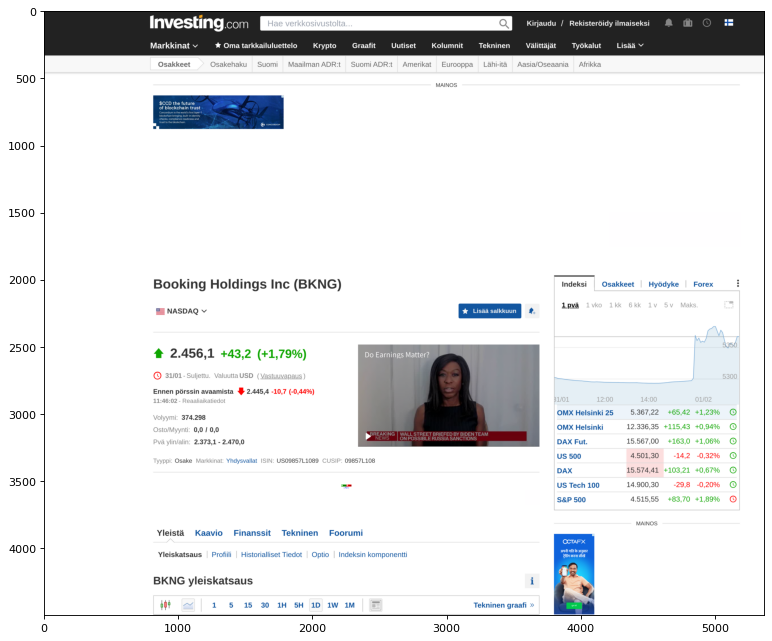

Running for the URL 18-  https://fi.investing.com/equities/nk-lukoil-oao?cid=942025


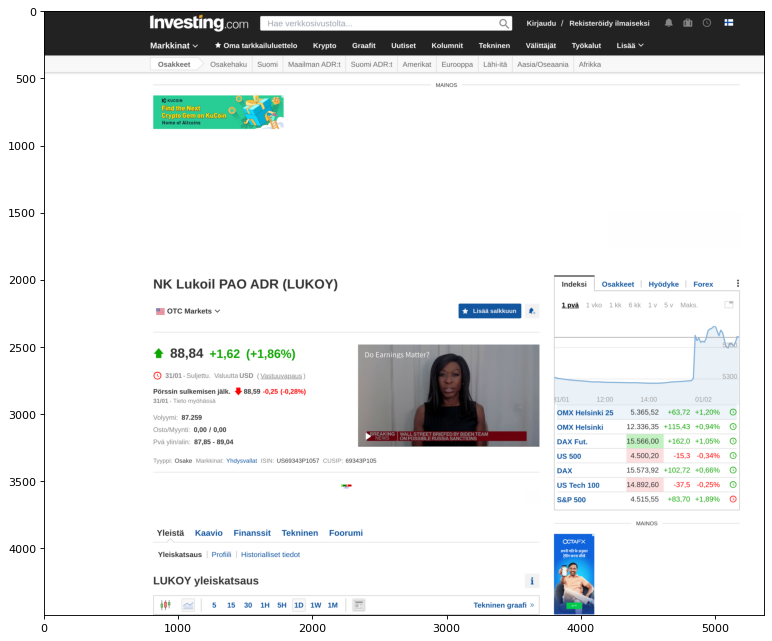

Running for the URL 19-  https://markets.ft.com/data/indices/tearsheet/summary?s=OMXN40:STO


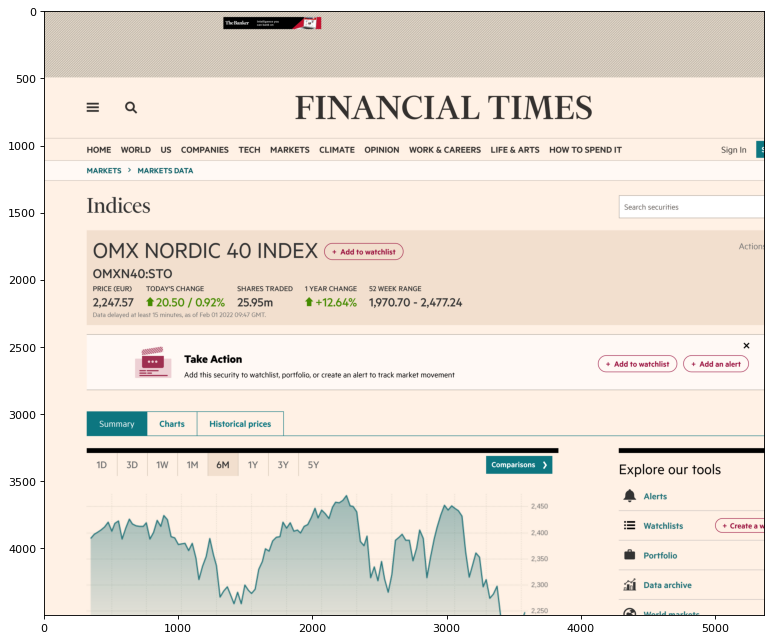

Running for the URL 20-  https://markets.ft.com/data/indices/tearsheet/summary?s=OMX30:STO


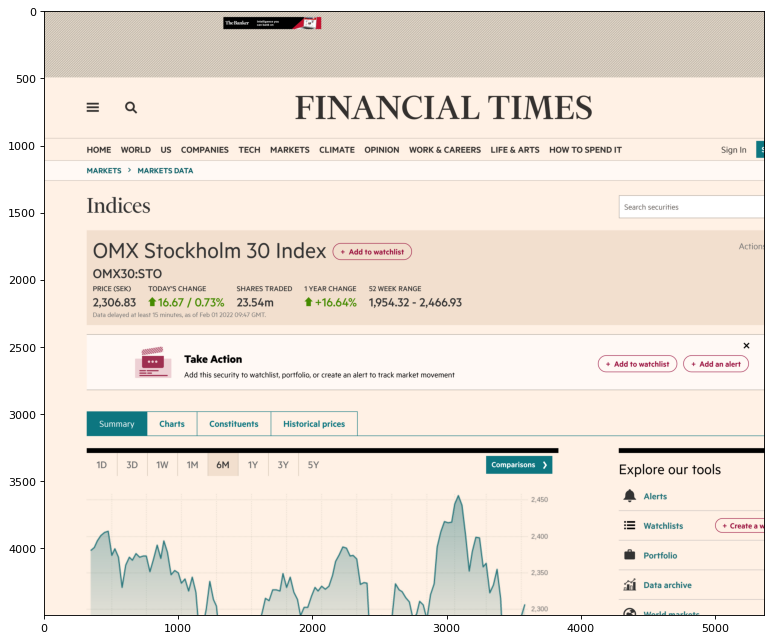

Running for the URL 21-  https://markets.ft.com/data/equities/tearsheet/summary?s=SHBI:NSQ


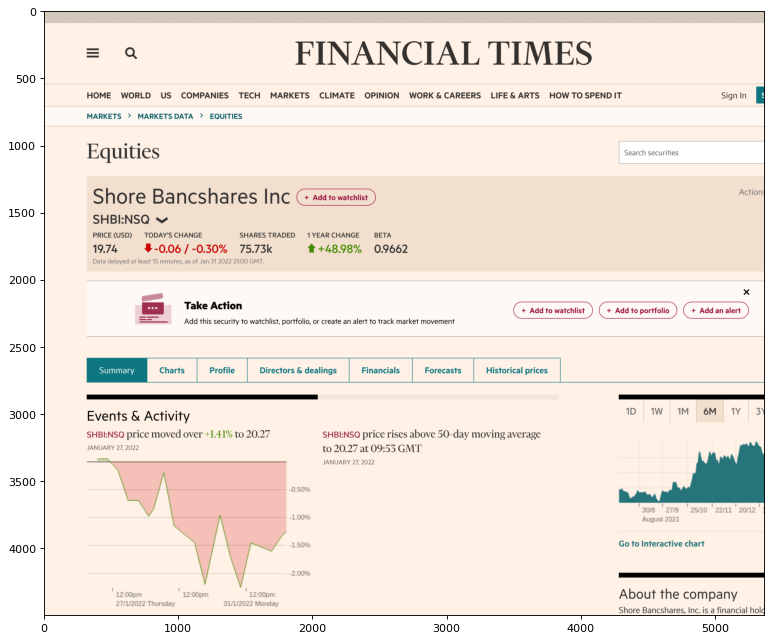

Running for the URL 22-  https://markets.ft.com/data/equities/tearsheet/summary?s=BKNG:NSQ


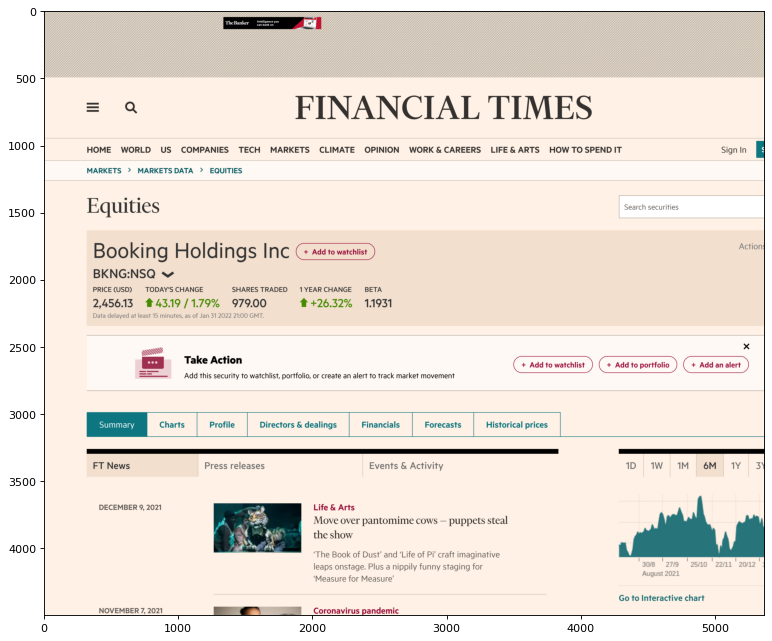

Running for the URL 23-  https://markets.ft.com/data/equities/tearsheet/summary?s=LUKOY:PKL
Running for the URL 24-  https://www.boursorama.com/bourse/indices/cours/%24OMXS30/


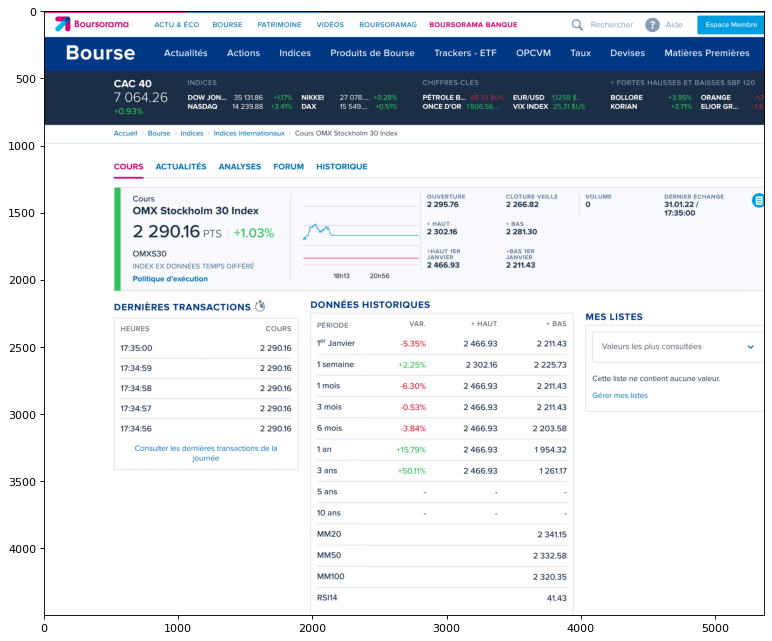

Running for the URL 25-  https://www.boursorama.com/cours/SHBI/


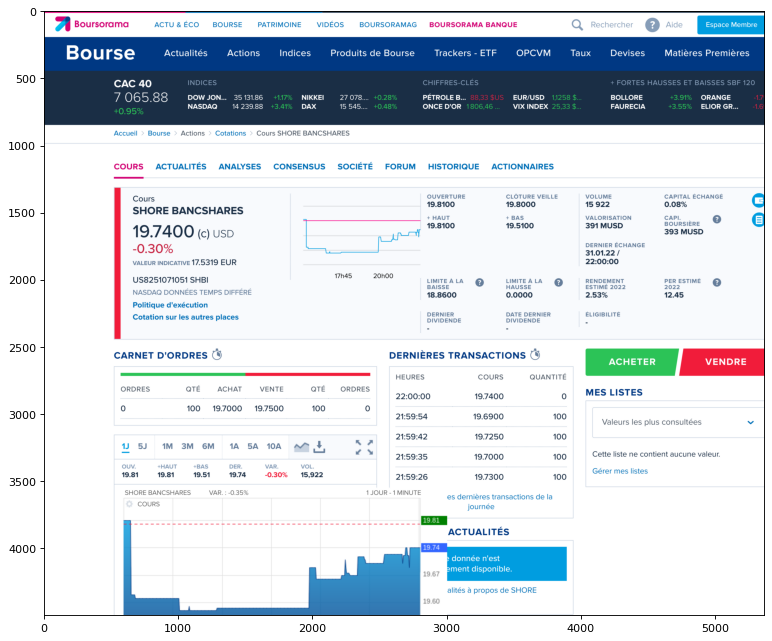

Running for the URL 26-  https://www.morningstar.dk/dk/etf/snapshot/snapshot.aspx?id=0P00000FYY


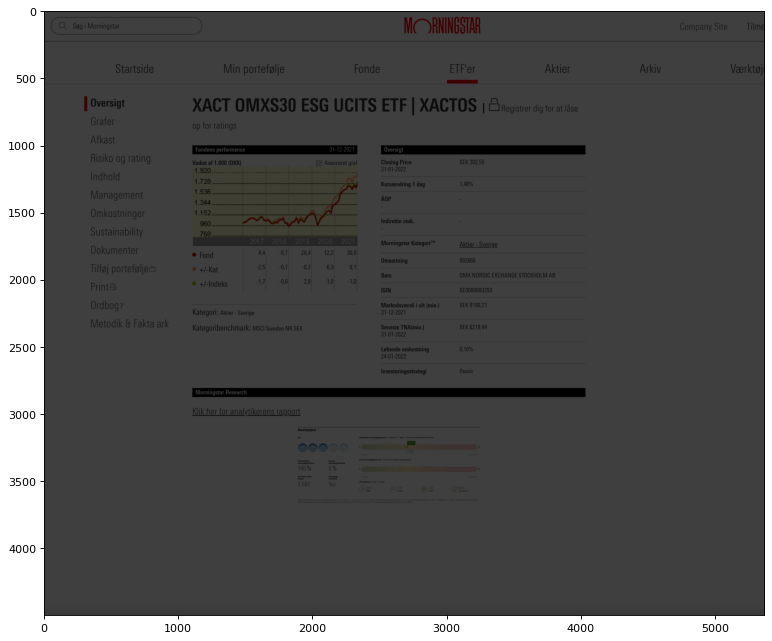

Running for the URL 27-  https://www.morningstar.co.uk/uk/etf/snapshot/snapshot.aspx?id=0P00000FYY


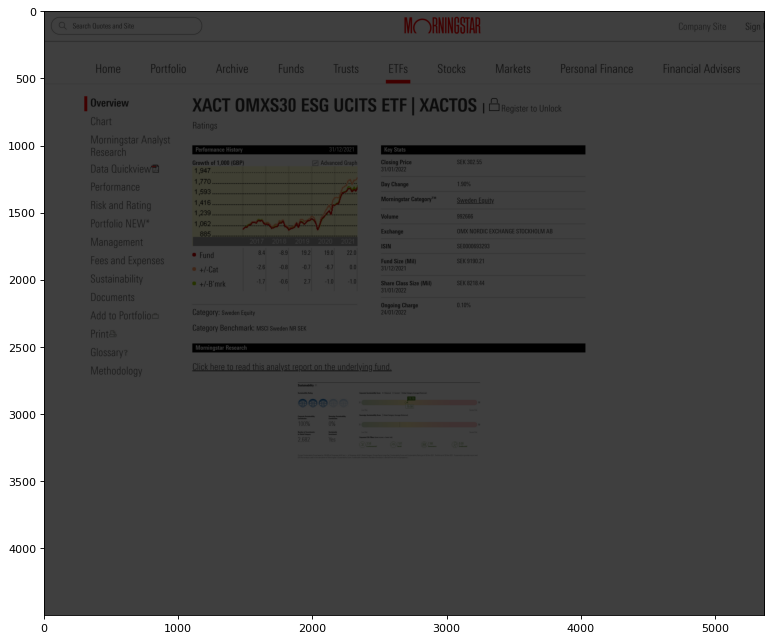

Running for the URL 28-  https://www.nordnet.fi/markkinakatsaus/indikaattori/omxs30


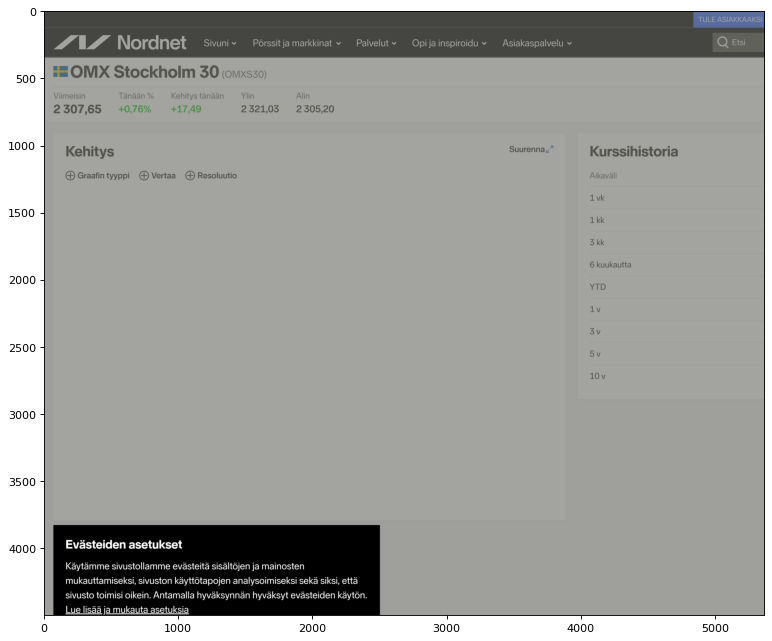

Running for the URL 29-  https://www.nordnet.fi/markkinakatsaus/indikaattori/omxn40


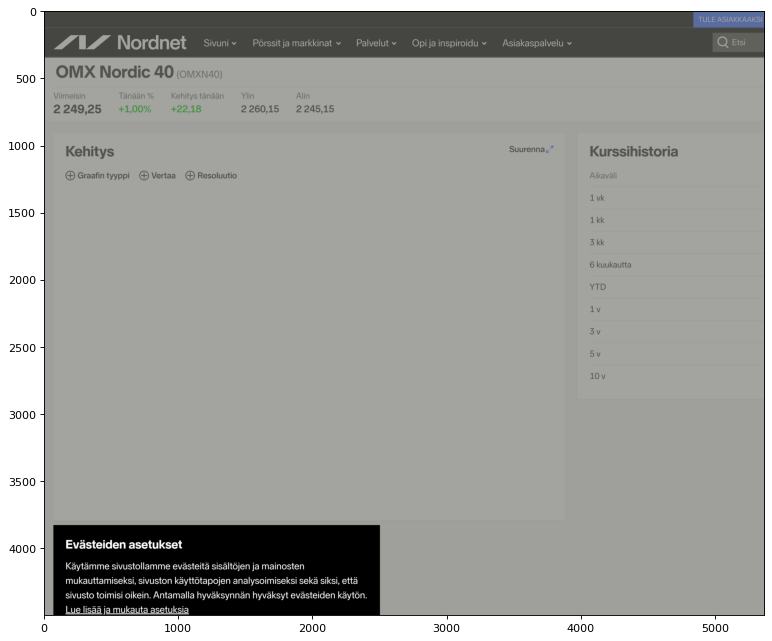

Running for the URL 30-  https://www.nordnet.fi/markkinakatsaus/osakekurssit/16832346-booking-holdings


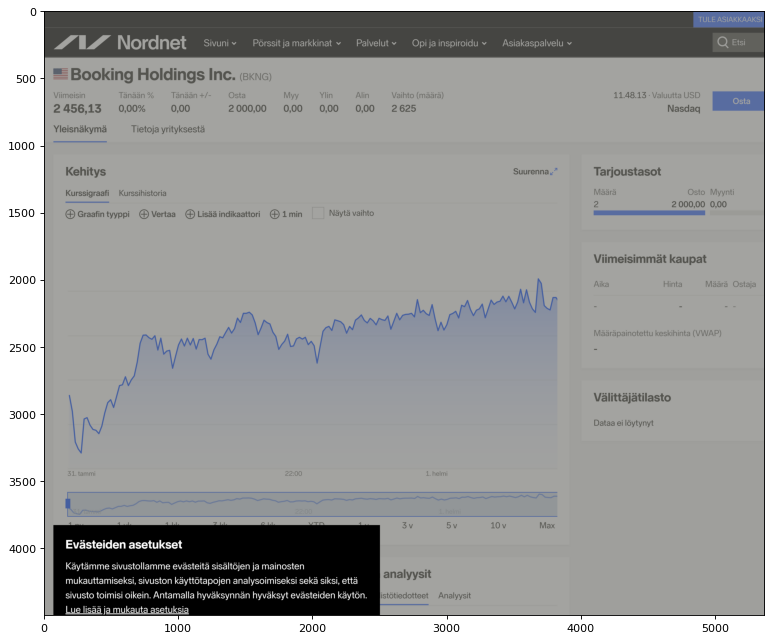

Running for the URL 31-  https://www.nordnet.fi/markkinakatsaus/osakekurssit/16119365-shore-bancshares


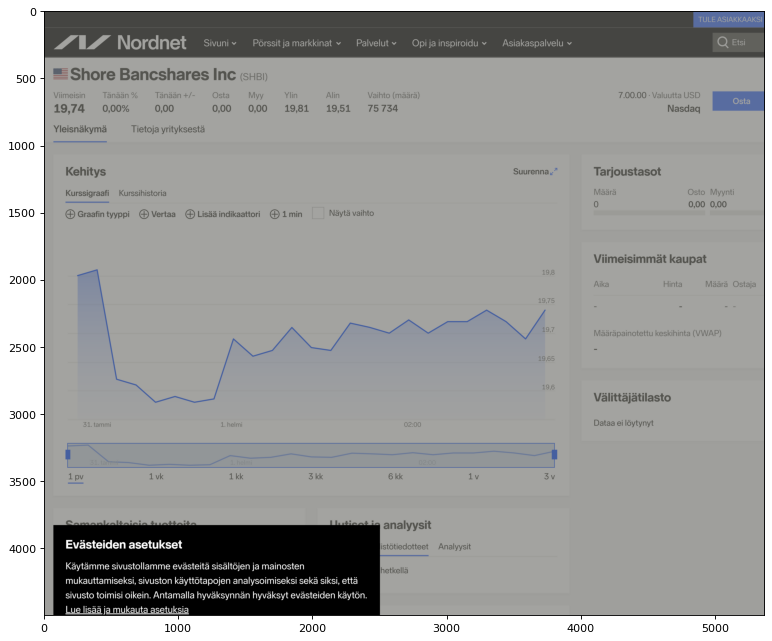

1485.9591720104218


In [25]:
import time
start = time.time()
raw_image_path='/root/Worley/mmdetection/inf/'
out_path='/root/Worley/mmdetection/check/'
unscraped_file='/root/Worley/mmdetection/demo3.xlsx'
# clear_folder(out_path)
# run_model(raw_image_path,out_path)
scraper(unscraped_file,raw_image_path,out_path)
end = time.time()
print(end - start)

In [21]:
print(end-start)

460.51411175727844


Fetching Websites 
Total Webistes - 7
Scraping the URL 1-  https://finance.yahoo.com/quote/SHBI/


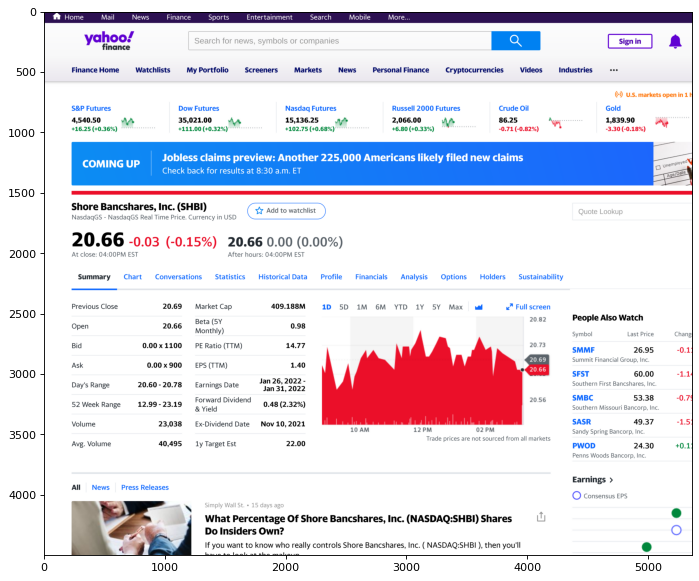

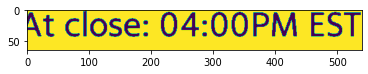

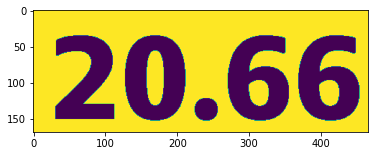

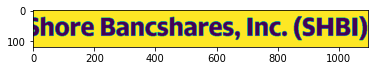

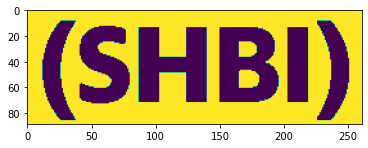

{'Date': 'At close: 04:00PM EST', 'Price': '20.66', 'Ticker': '(SHBI)', 'Stock': 'Shore Bancshares, Inc.(SHBI)'} 

Scraping the URL 2-  https://www.marketbeat.com/stocks/OTCMKTS/LUKOY/


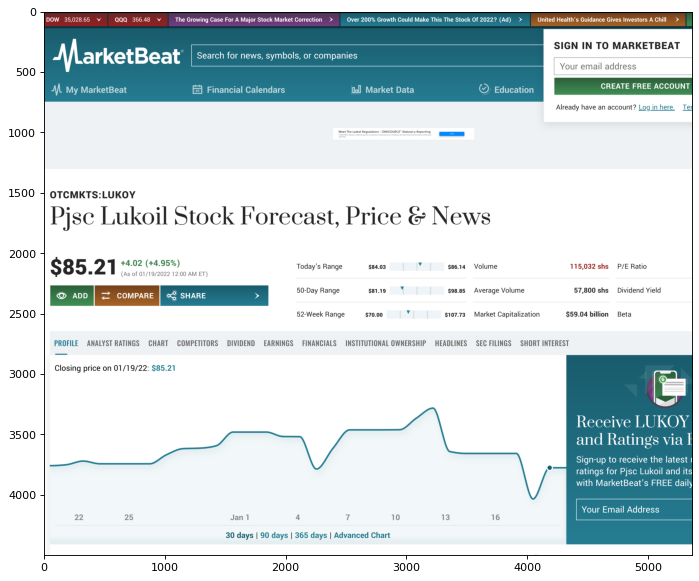

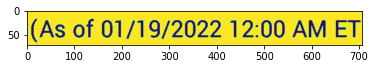

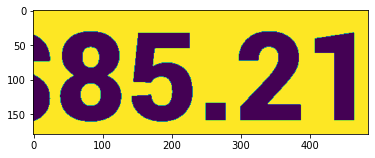

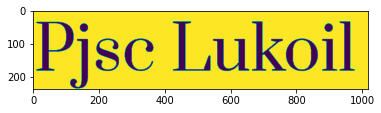

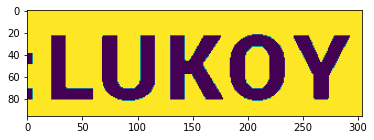

{'Date': '(As of 01/19/2022 12:00 AM ET', 'Price': '85.21', 'Ticker': 'LUKOY', 'Stock': 'Pjsc Lukoil'} 

Scraping the URL 3-  https://markets.businessinsider.com/index/nasdaq_100


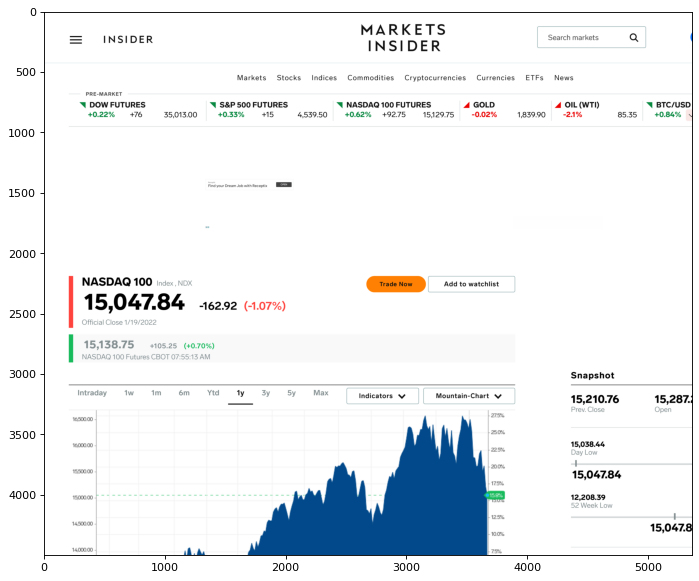

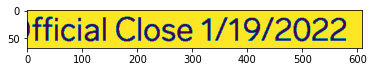

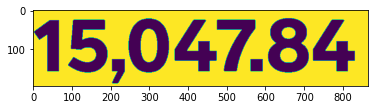

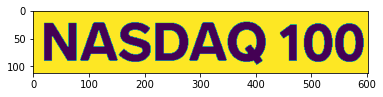

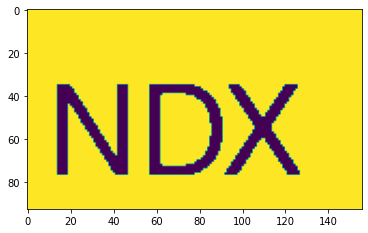

{'Date': 'fficial Close 1/19/2022', 'Price': '15,047.84', 'Ticker': 'NDX', 'Stock': 'NASDAQ 100'} 

Scraping the URL 4-  http://www.morningstar.co.uk/uk/etf/snapshot/snapshot.aspx?id=0P00000K38


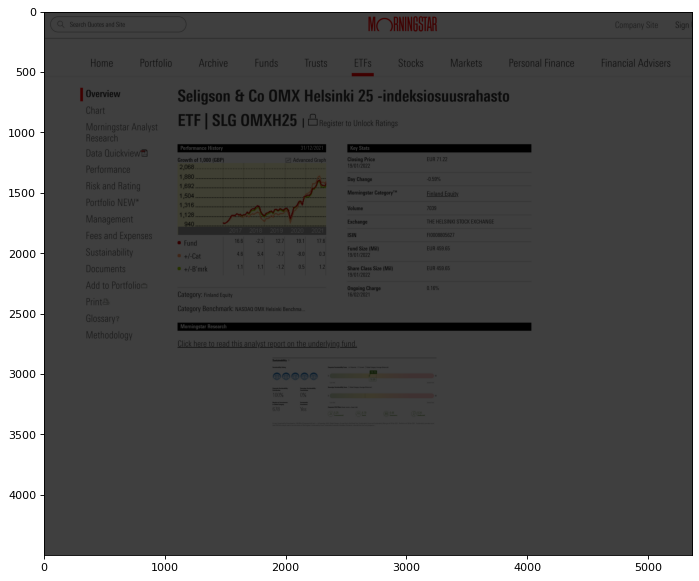

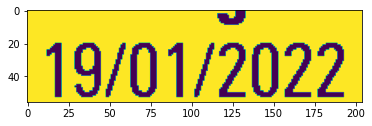

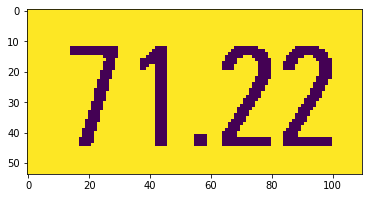

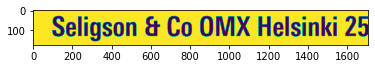

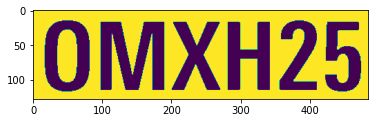

{'Date': '19/01/2022', 'Price': '71.22', 'Ticker': 'OMXH25', 'Stock': 'Seligson'} 

Scraping the URL 5-  https://www.centralcharts.com/en/53597-omx-stockholm-30/quotes
Message: timeout: Timed out receiving message from renderer: 10.000
  (Session info: headless chrome=90.0.4430.93)
Stacktrace:
#0 0x55d4017583e9 base::debug::CollectStackTrace()
#1 0x55d401709ef6 base::debug::StackTrace::StackTrace()
#2 0x55d4010e1ba0 Status::Status()
#3 0x55d4010d23f8 DevToolsClientImpl::ProcessNextMessage()
#4 0x55d4010d307e DevToolsClientImpl::SendCommandInternal()
#5 0x55d4010d35c9 DevToolsClientImpl::SendCommandAndGetResultWithTimeout()
#6 0x55d4010e4719 WebViewImpl::CaptureScreenshot()
#7 0x55d40116705d ExecuteScreenshot()
#8 0x55d40112e5c4 base::internal::Invoker<>::Run()
#9 0x55d4011591b0 ExecuteWindowCommand()
#10 0x55d40112e787 base::internal::Invoker<>::Run()
#11 0x55d401114566 (anonymous namespace)::ExecuteSessionCommandOnSessionThread()
#12 0x55d401112184 base::internal::Invoker<>::RunOnce()

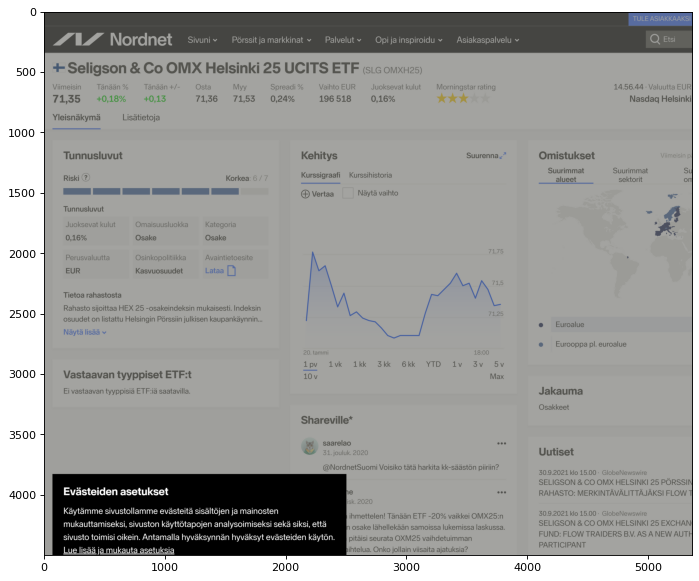

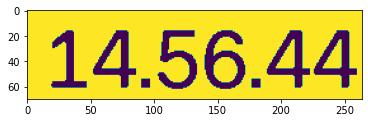

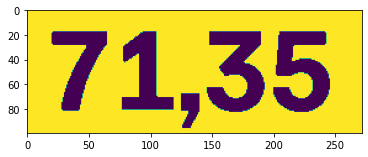

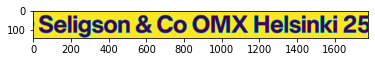

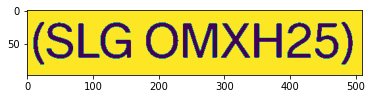

{'Date': '14.56.44', 'Price': '71,35', 'Ticker': '(SLG OMXH25)', 'Stock': 'Seligson  Co OMX Helsinki 25'} 

Scraping the URL 7-  https://www.avanza.se/index/om-indexet.html/53548/omx-nordic-40


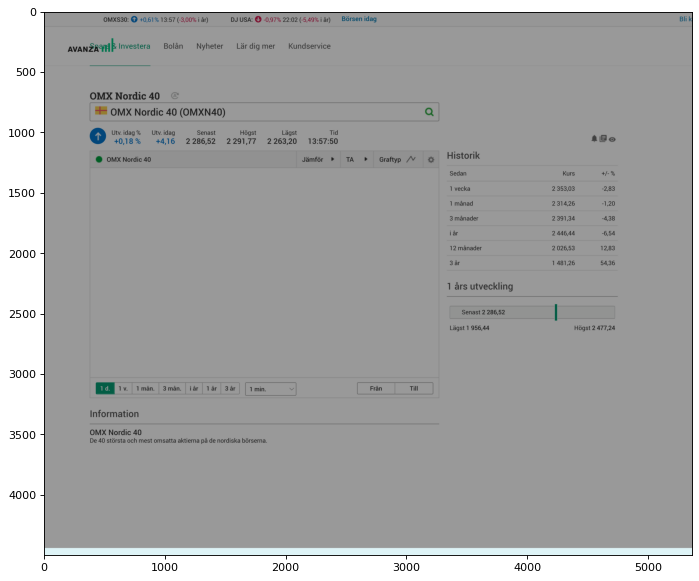

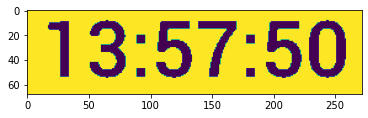

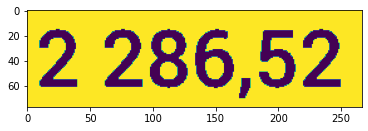

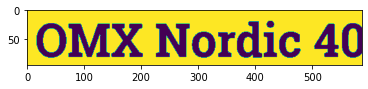

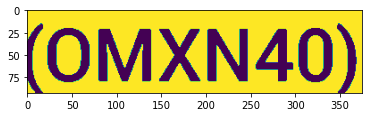

{'Date': '13:57:50', 'Price': '2286,52', 'Ticker': '(OMXN40)', 'Stock': 'OMX Nordic 40'} 

Saving the results into CSV file


In [37]:
unscraped_file='/root/Worley/mmdetection/stock ticker unscraped sites.xlsx'
df=pd.read_excel(unscraped_file,sheet_name='Sheet1')  
print('Fetching Websites ')
print('Total Webistes -',len(df['Website URL'].tolist()))
final={}
driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chromeOptions)
for index,url in enumerate(df['Website URL'].tolist()):
    print("Scraping the URL "+str(index+1)+"- ",url)
    name=url[8:].split('/')[0]+'_'+str(index)
    try:
        driver.get(url)
        driver.implicitly_wait(10)
        driver.set_page_load_timeout(120)
        driver.execute_script("document.body.style.zoom = '450%'")
        element = driver.find_element_by_tag_name('body')
        location = element.location
        size = element.size
        png = driver.get_screenshot_as_png()
    #     driver.quit()
        right=(location['x'] + size['width']) * 4.5
        left = location['x'] * 4.5
        top = location['y'] * 4.5
        im = Image.open(BytesIO(png))
        im=im.crop((left+20,top,right-600,4500))
        figure(figsize=(12, 9), dpi=80)
        plt.imshow(im)
        plt.show()
        temp_path='/root/Worley/mmdetection/inf/temp.png'
        temp_out='/root/Worley/mmdetection/temp out/'
        im.save(temp_path)
        res=get_cord(model,temp_path)
        result=save_img(temp_path,res,temp_out)
        print(result,'\n')
        final[url]=result
    except Exception as e:
        print('Exception occured while scraping the site')
driver.quit()
save_result(final)

In [18]:
final={}
driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chromeOptions)
url='https://www.investing.com/indices/nasdaq-composite-candlestick'
name=url[8:].split('/')[0]+'_'+str(0)
try:
    driver.get(url)
#     driver.implicitly_wait(10)
#     driver.set_page_load_timeout(120)
    driver.execute_script("document.body.style.zoom = '450%'")
    element = driver.find_element_by_tag_name('body')
    location = element.location
    size = element.size
    png = driver.get_screenshot_as_png()
    driver.quit()
    right=(location['x'] + size['width']) * 4.5
    left = location['x'] * 4.5
    top = location['y'] * 4.5
    im = Image.open(BytesIO(png))
    im=im.crop((left+20,top,right-600,4500))
    figure(figsize=(12, 9), dpi=80)
    plt.imshow(im)
    plt.show()
    temp_path='/root/Worley/mmdetection/inf/'+name+'.png'
    temp_out='/root/Worley/mmdetection/temp out/'
    im.save(temp_path)
    res=get_cord(model,temp_path)
    result=save_img(temp_path,res,temp_out)
    print(result,'\n')
    final[url]=result
except Exception as e:
    print(e)
driver.quit()

Message: timeout: Timed out receiving message from renderer: 298.279
  (Session info: headless chrome=90.0.4430.93)
Stacktrace:
#0 0x56118149a3e9 base::debug::CollectStackTrace()
#1 0x56118144bef6 base::debug::StackTrace::StackTrace()
#2 0x561180e23ba0 Status::Status()
#3 0x561180e143f8 DevToolsClientImpl::ProcessNextMessage()
#4 0x561180e1507e DevToolsClientImpl::SendCommandInternal()
#5 0x561180e155c9 DevToolsClientImpl::SendCommandAndGetResultWithTimeout()
#6 0x561180e20264 NavigationTracker::IsPendingNavigation()
#7 0x561180e2afd6 WebViewImpl::IsNotPendingNavigation()
#8 0x561180e24dab base::internal::Invoker<>::Run()
#9 0x561180e14673 DevToolsClientImpl::HandleEventsUntil()
#10 0x561180e2e329 WebViewImpl::WaitForPendingNavigations()
#11 0x561180e9b325 ExecuteWindowCommand()
#12 0x561180e70787 base::internal::Invoker<>::Run()
#13 0x561180e56566 (anonymous namespace)::ExecuteSessionCommandOnSessionThread()
#14 0x561180e54184 base::internal::Invoker<>::RunOnce()
#15 0x561181471952 ba

In [15]:
import threading
from multiprocessing.pool import ThreadPool, Pool
threadLocal = threading.local()

In [16]:
def get_driver():
    driver = getattr(threadLocal, 'driver', None)
    if driver is None:
        driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chromeOptions)
        setattr(threadLocal, 'driver', driver)
    return driver

In [23]:
def runner(url):
    print(url)
    final={}
    name=url[8:].split('/')[0]+'_'+str(0)
#     driver = get_driver()
    try:
        driver=get_driver()
        driver.get(url)
#         driver.implicitly_wait(10)
#         driver.set_page_load_timeout(120)
        driver.execute_script("document.body.style.zoom = '450%'")
        element = driver.find_element_by_tag_name('body')
        location = element.location
        size = element.size
        print(url,size)
        png = driver.get_screenshot_as_png()
        driver.quit()
        right=(location['x'] + size['width']) * 4.5
        left = location['x'] * 4.5
        top = location['y'] * 4.5
        im = Image.open(BytesIO(png))
        im=im.crop((left+20,top,right-600,4500))
        figure(figsize=(12, 9), dpi=80)
        plt.imshow(im)
        plt.show()
        temp_path='/root/Worley/mmdetection/inf/'+name+'.png'
        temp_out='/root/Worley/mmdetection/temp out/'
        im.save(temp_path)
        res=get_cord(model,temp_path)
        result=save_img(temp_path,res,temp_out)
        print(result,'\n')
        final[url]=result
    except Exception as e:
        print(e)
    return final

In [ ]:
import time
start = time.time()
unscraped_file='/root/Worley/mmdetection/stock ticker unscraped sites.xlsx'
df=pd.read_excel(unscraped_file,sheet_name='Sheet1')  
print('Fetching Websites ')
total_sites=df['Website URL'].tolist()
print('Total Webistes -',len(total_sites))
total_sites=total_sites[:2]
# driver = webdriver.Chrome('/usr/bin/chromedriver',chrome_options=chromeOptions)
with ThreadPoolExecutor(max_workers=2) as exe:
        final=exe.map(runner,total_sites)
driver.quit()
# ThreadPool(7).map(runner,total_sites)
end = time.time()
print(end - start)